<font size="5">

# Multi-Grid measurements at LET 2022 - preparations

<font size="3">

> __Author:__ A. Backis
<br/>__Institute:__ University of Glasgow (UoG), European Spallation Source (ESS)
<br/>__Date:__ 6/10-2021

_Abstract:_
This notebook contains the data analysis used for the preparations leading up to the LET measurements with the Multi-Grid detector.

# Contents
    
* [1. Introduction](#INTRODUCTION)
    * [1.1 Packages](#PACKAGES)
    * [1.2 Parameters](#PARAMETERS)
* [2. Validation](#VALIDATION)
    * [2.1 Parsing](#PARSING)
    * [2.2 Clustering](#CLUSTERING)
* [3. Utgård](#UTGÅRD) 

# 1. Introduction<a class="anchor" id="INTRODUCTION"></a>

Notebook showing the preparations leading up to the LET measurements.

## 1.1 Packages<a class="anchor" id="PACKAGES"></a>

Import necessary packages.

In [2]:
# Autoload packages when doing an external change
%load_ext autoreload
%autoreload 2

# Activate matplotlib in interactive notebook mode
%matplotlib widget

# Ensure custom packages can be reached
import os
import sys
import json
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# General packages
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import plotly as py
import plotly.graph_objs as go
import matplotlib.patheffects as path_effects

# Custom packages
import file_handling.mg_vmm_read as mg_read
import file_handling.mg_vmm_cluster as mg_cluster
import plotting.mg_vmm_basic_plot as mg_plot
import plotting.mg_vmm_debug as mg_debug
import mbuty.libTerminal as ta

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1.2 Parameters<a class="anchor" id="PARAMETERS"></a>

Define global parameters.

In [3]:
# Constants
MODERATOR_TO_SAMPLE_IN_M = 25
CSPEC_TYPE = 64
TIME_RESOLUTION = 11.36e-9 # seconds

# Paths to folders containing data
nb_path = os.getcwd()
TEST_FOLDER = nb_path + '/../data/test/'

Prepare JSON file defining detector configuration.

In [4]:
configuration_dict = {'detector': 'MG_LET',
                      'columns': 2,
                      'grids_per_column': 51,
                      'rows_per_grid': 6,
                      'layers_per_grid': 16,
                      'voxel_pitch_x_in_mm': 22.5, 
                      'voxel_pitch_y_in_mm': 22.5, # This should be a bit more due to spacing between adjacent grids
                      'voxel_pitch_z_in_mm': 10,
                      'wire_asic': 0,
                      'grid_asic': 1,
                      'column_to_electronic': {0: {'Ring': 0, 'FEN': 1, 'Hybrid': 0},
                                               1: {'Ring': 0, 'FEN': 1, 'Hybrid': 1}}
                      }

Declare helper function to transfer data to data folder.

In [5]:
def update_data(source_path, destination_path):
    transferData = ta.transferDataUtil()
    transferData.syncData(source_path, destination_path)

# 2. Validation<a class="anchor" id="VALIDATION"></a>

Here we are going to validate that the code is working as expected. Starting with the data parser and progressively moving towards the more advanced features.

## 2.1. Parsing<a class="anchor" id="PARSING"></a>

In [12]:
# Parse test data
#df_freia_test = mg_read.read_vmm_data(TEST_FOLDER + 'freiatest.pcapng')
#df_let_test = mg_read.read_vmm_data(TEST_FOLDER + 'cspec_for_alex.pcapng')
df_cspec_for_alex_2 = mg_read.read_vmm_data(TEST_FOLDER + 'cspec_for_alex_2.pcapng')
#df_frapi_test_1 = mg_read.read_vmm_data(TEST_FOLDER + '20220224_161540_duration_s_5_run_2_00000.pcapng')

/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/plotting/mg_vmm_basic_plot.py:166: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


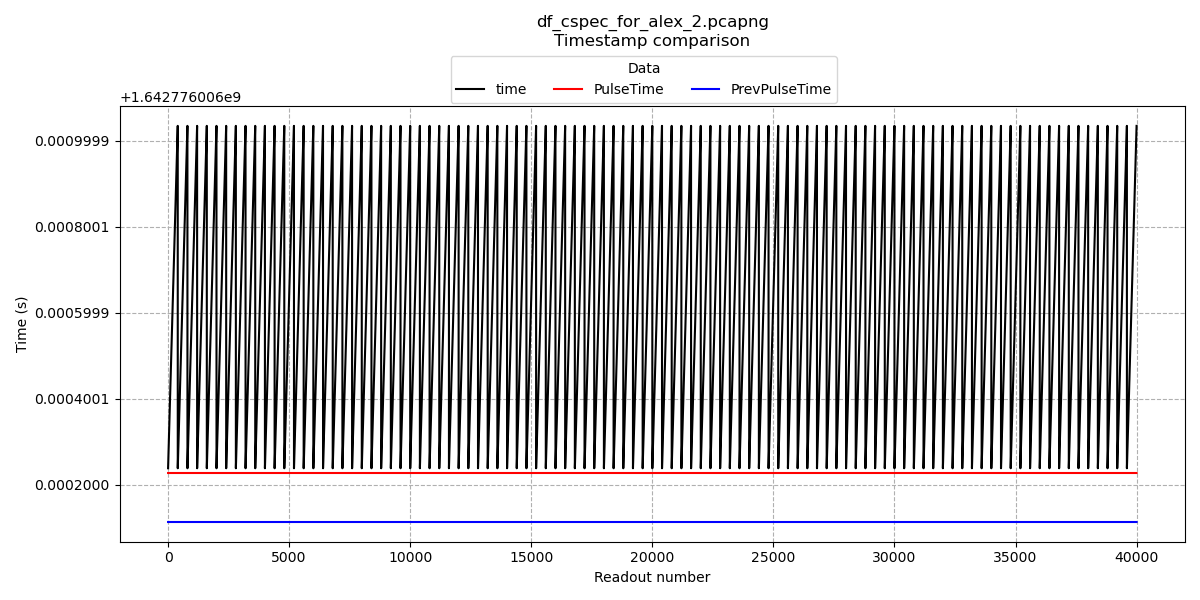

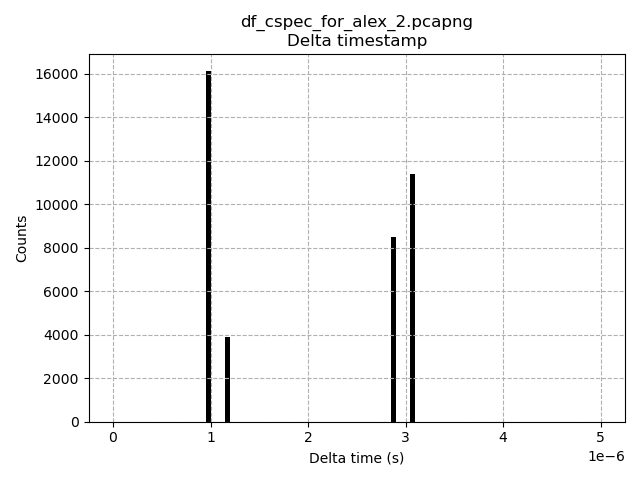

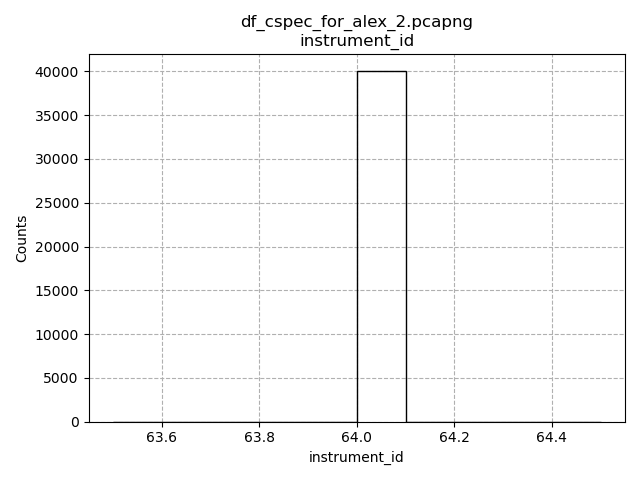

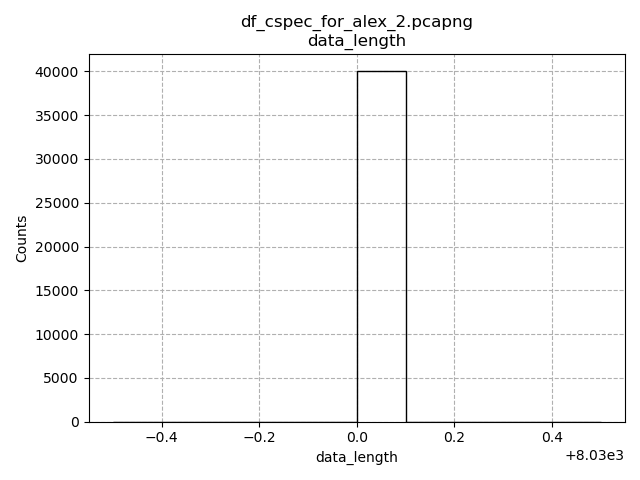

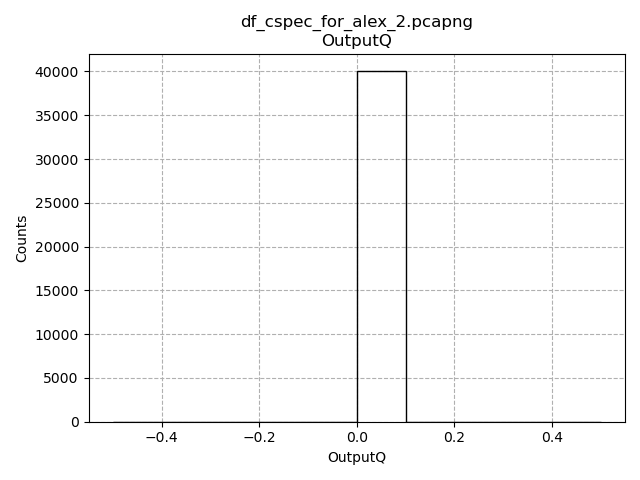

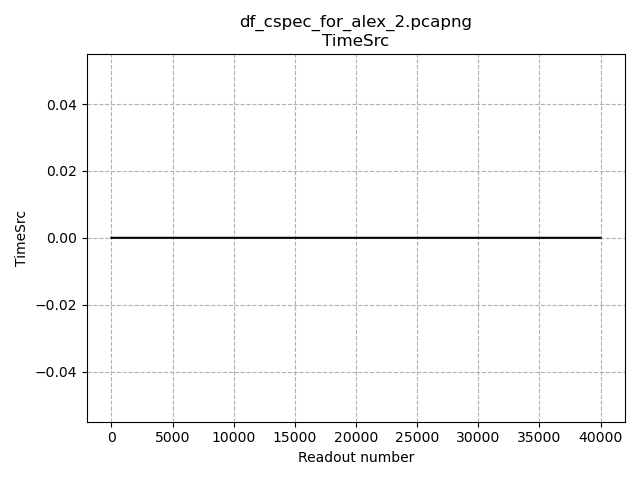

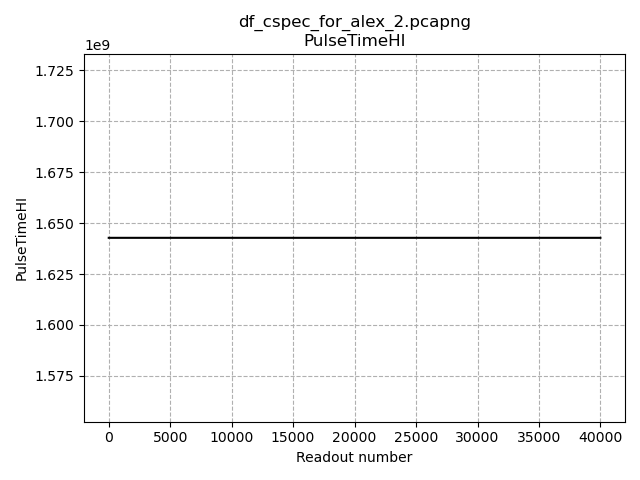

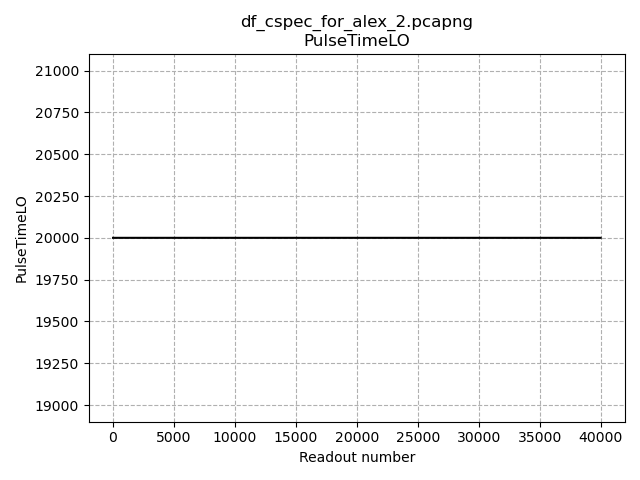

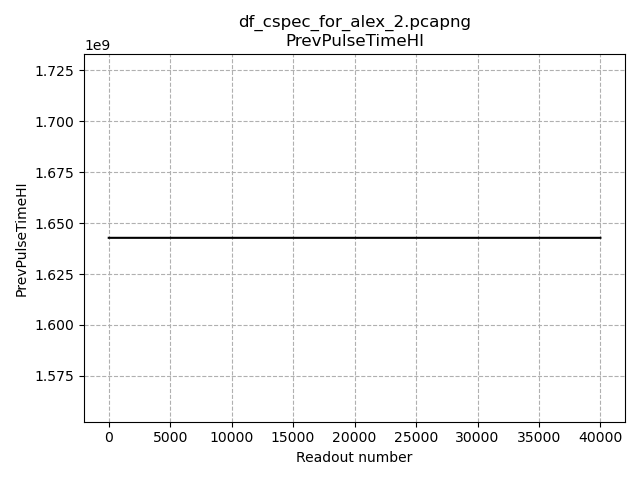

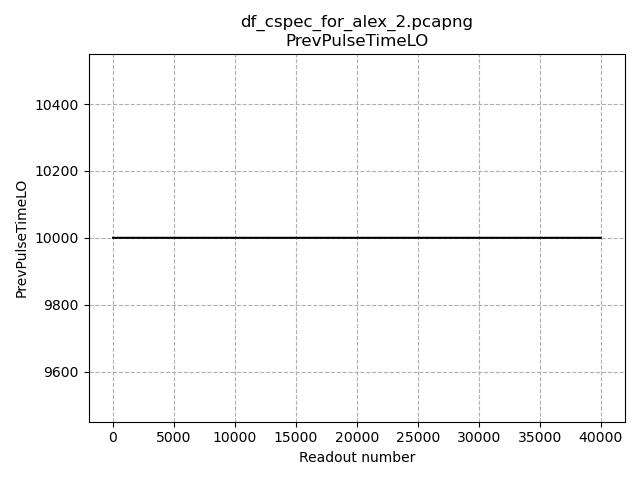

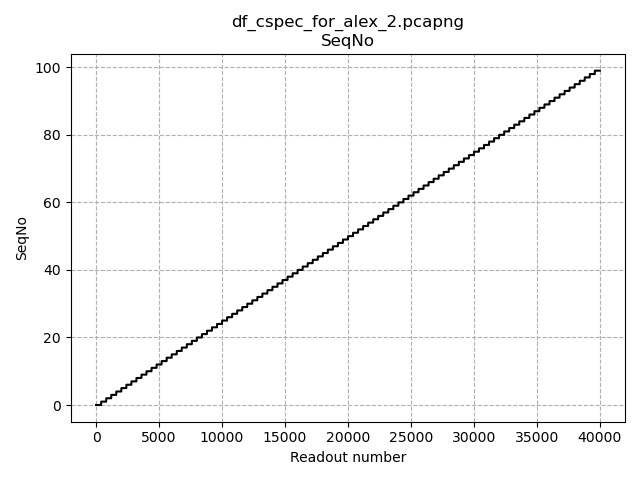

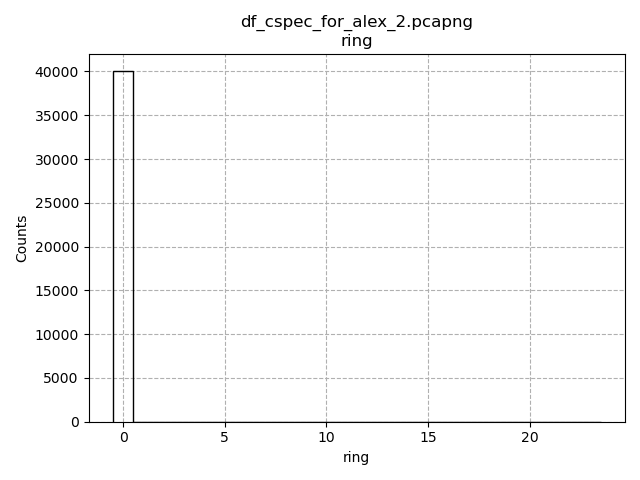

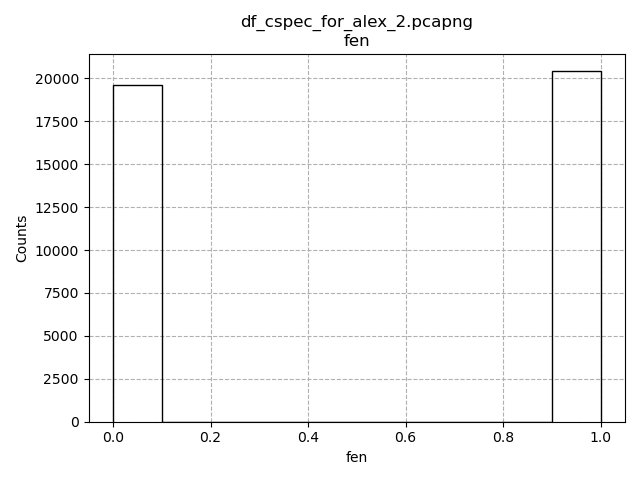

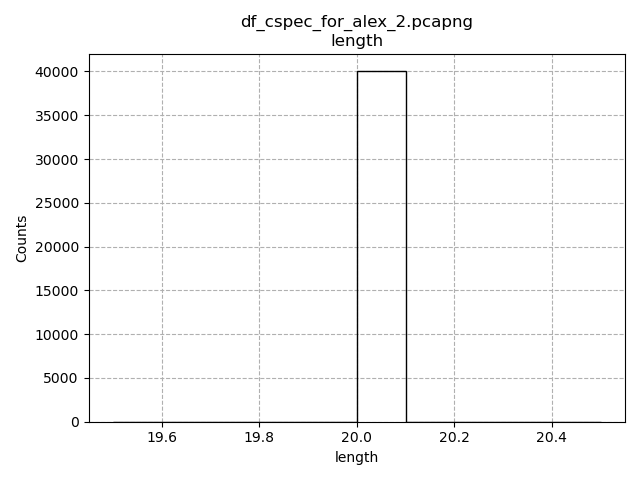

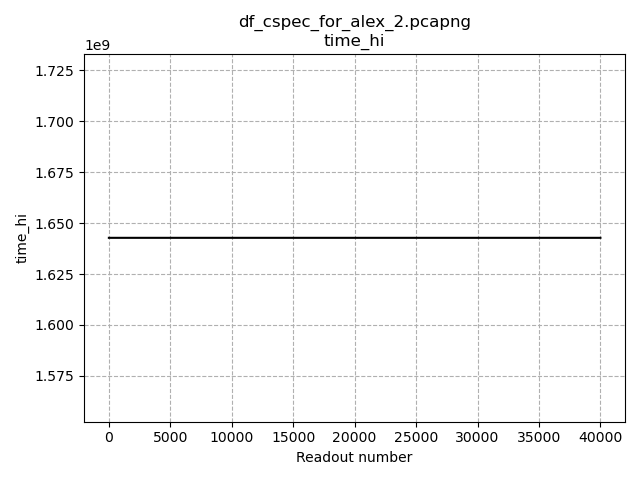

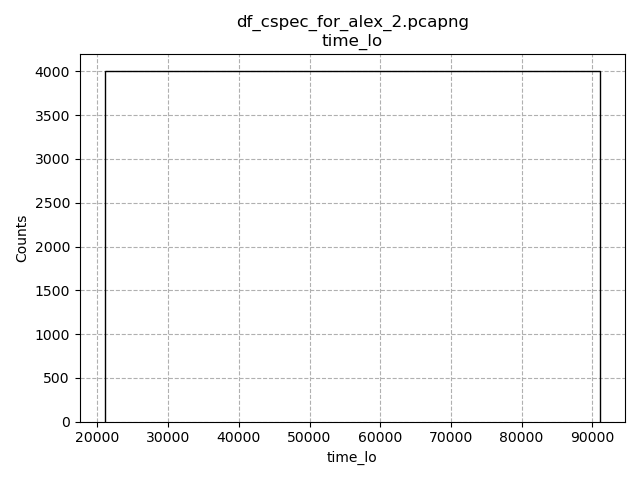

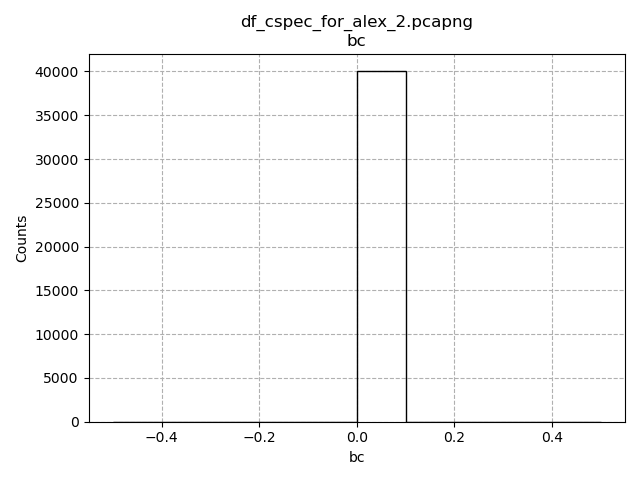

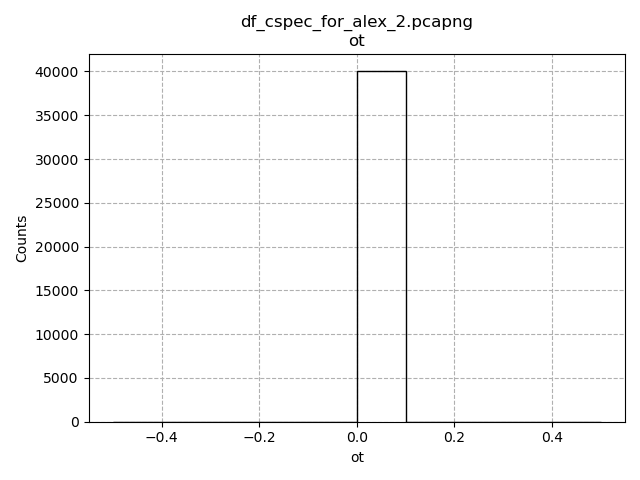

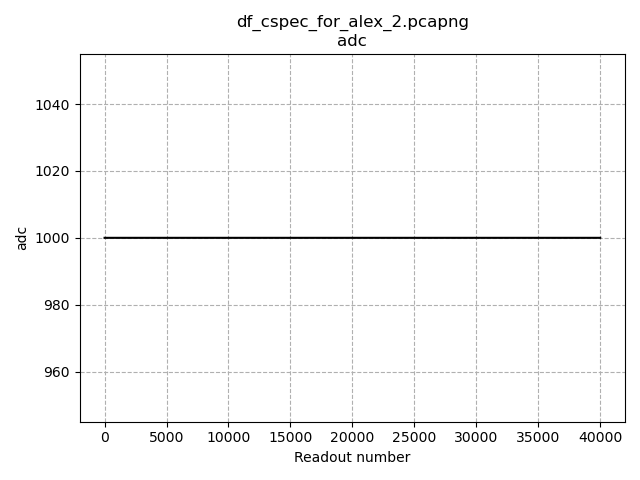

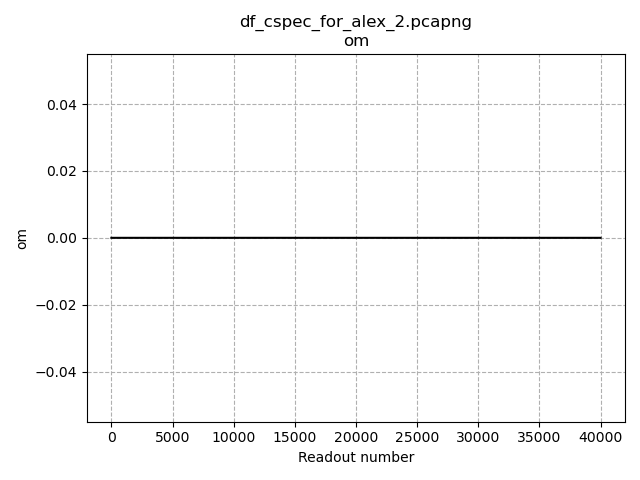

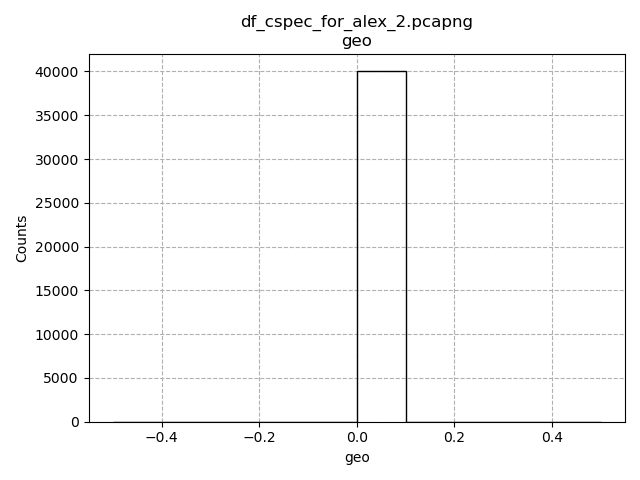

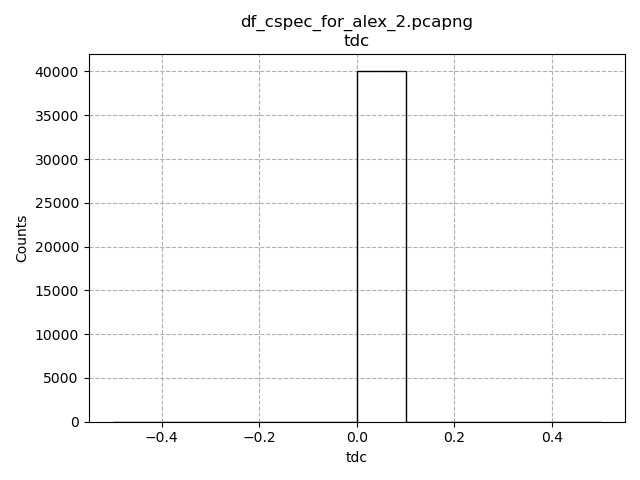

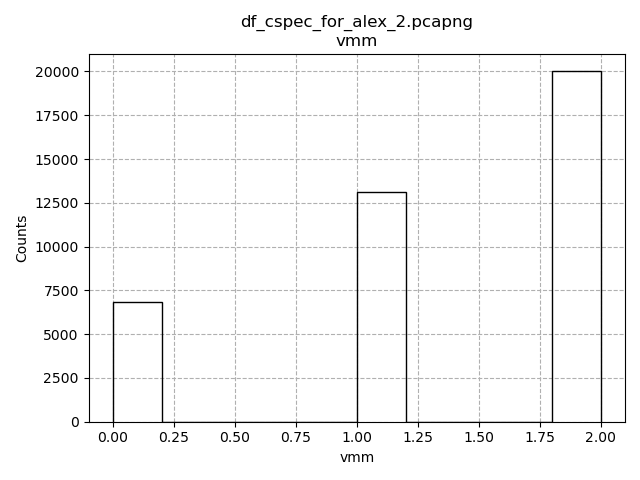

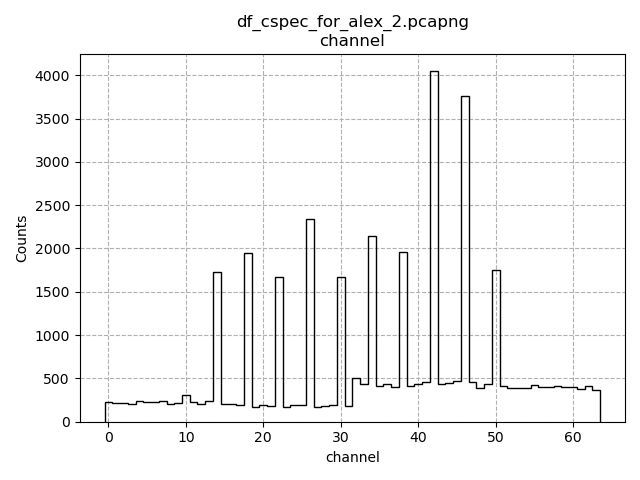

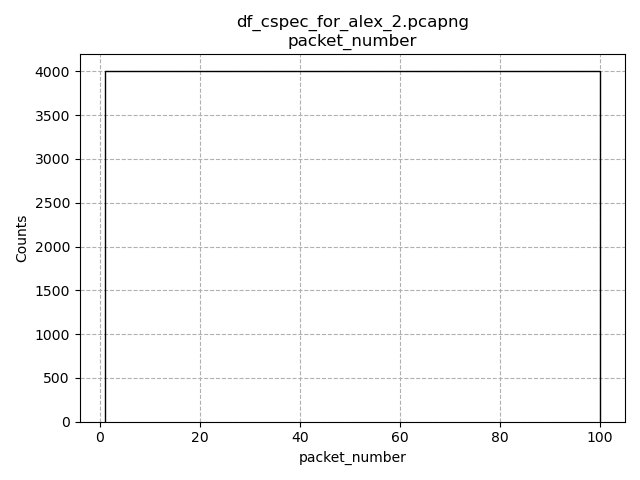

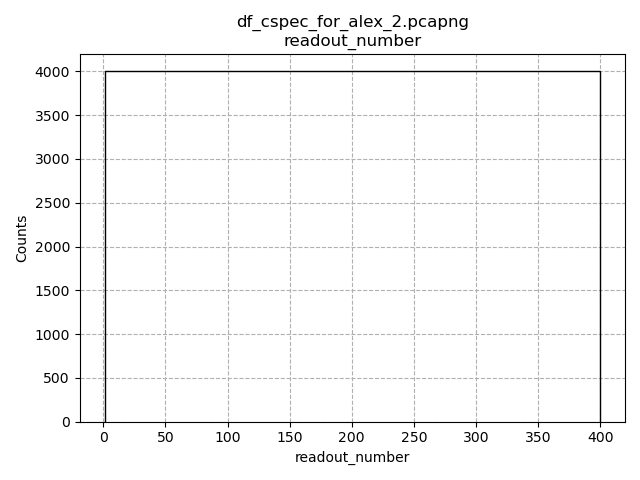

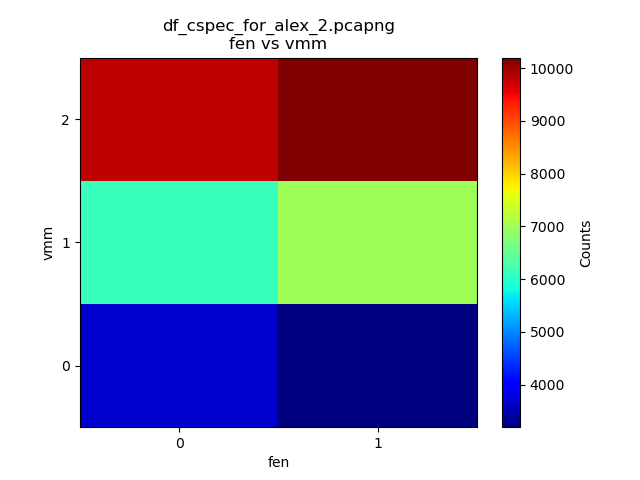

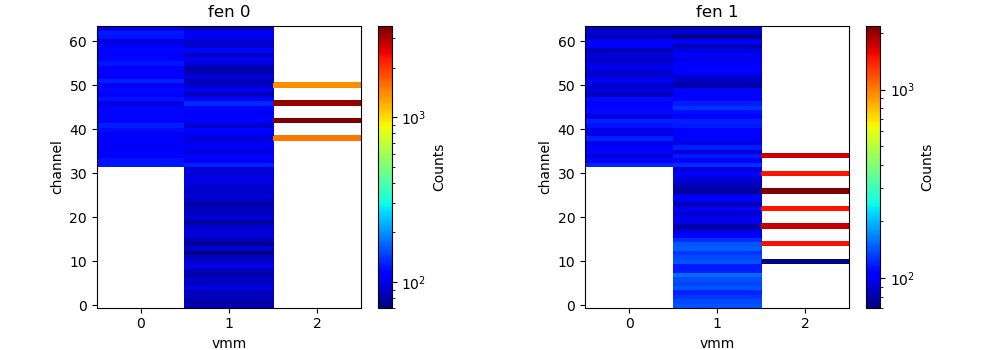

In [13]:
# Plot some test data
mg_plot.plot_vmm_data(df_cspec_for_alex_2, 'df_cspec_for_alex_2')
mg_plot.plot_time_stamp(df_cspec_for_alex_2, (1 / (88.0525 * 1e6)), 'df_cspec_for_alex_2')
mg_plot.plot_fen_and_vmm(df_cspec_for_alex_2, 'df_cspec_for_alex_2')
mg_plot.plot_vmm_and_channel_events(df_cspec_for_alex_2, 'df_cspec_for_alex_2')

In [ ]:
mg_plot.plot_vmm_data(df_cspec_for_alex_2, 'cspec_for_alex_2')

## 2.2. Clustering<a class="anchor" id="CLUSTERING"></a>

In [ ]:
# Cluster test data
df_clusters_cspec_for_alex_2 = mg_cluster.cluster_vmm_data(df_cspec_for_alex_2)

In [ ]:
# Plot some test data
mg_plot.plot_vmm_and_channel(df_clusters_cspec_for_alex_2, 'cspec_for_alex_2')
mg_plot.plot_multiplicity(df_clusters_cspec_for_alex_2, 'cspec_for_alex_2')
mg_plot.plot_tof(df_clusters_cspec_for_alex_2, 'cspec_for_alex_2')
mg_plot.plot_3D_hist(df_clusters_cspec_for_alex_2, 'cspec_for_alex_2')

# 3. Utgård<a class="anchor" id="UTGÅRD"></a>


 ... syncing data ...

 data sync completed

-----


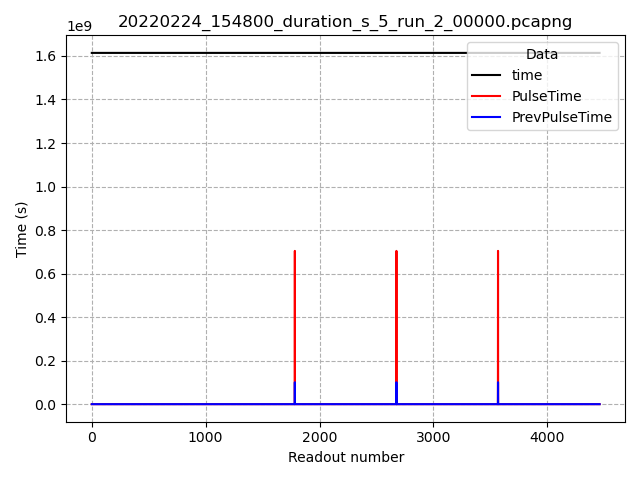

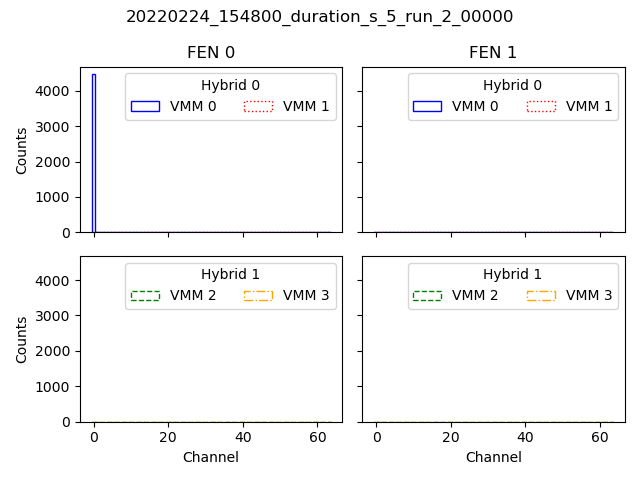

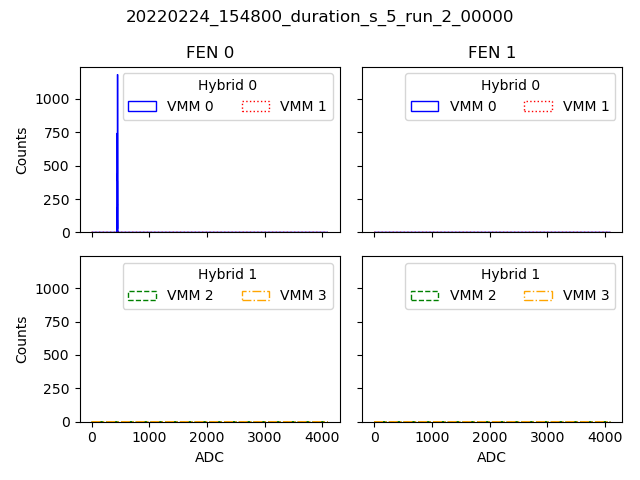

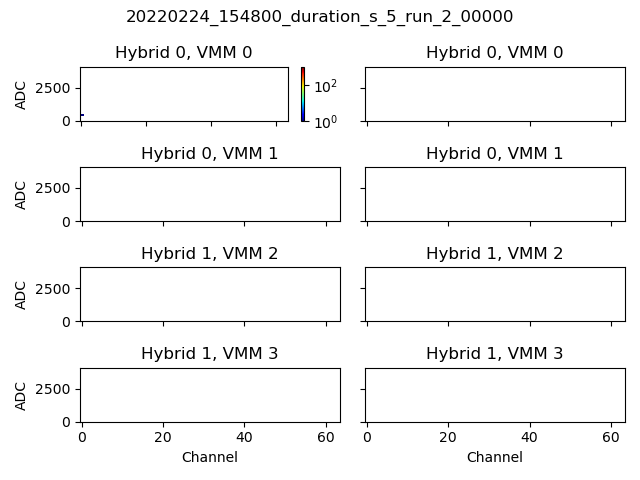

In [22]:
# Define data paths
remote_data_folder = 'essdaq@172.30.244.233:~/pcaps/'
local_data_folder = '/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/data/readout_tests/'
# Update data
update_data(remote_data_folder, local_data_folder)
# Declare path to file of interest
file_name = '20220224_154800_duration_s_5_run_2_00000'
file_path = local_data_folder + file_name + '.pcapng'
# Import  data
df_run_0 = mg_read.read_vmm_data(file_path)
mg_debug.plot_channel_histograms(df_run_0, file_name)
mg_debug.plot_adc_histograms(df_run_0, file_name)
mg_debug.plot_channel_vs_adc_2d_histograms(df_run_0, file_name)
mg_debug.plot_time_stamp(df_run_0, TIME_RESOLUTION, file_name)